### Plot Function

In [9]:
import matplotlib.pyplot as plt
titles = [
        "Pressure",
        "Temperature",
        "Temperature in Kelvin",
        "Temperature (dew point)",
        "Relative Humidity",
        "Saturation vapor pressure",
        "Vapor pressure",
        "Vapor pressure deficit",
        "Specific humidity",
        "Water vapor concentration",
        "Airtight",
        "Wind speed",
        "Maximum wind speed",
        "Wind direction in degrees",
        "Rainfall (in millimeters)",
        "Raining duration (in seconds)",
        "Solar Radiation (in watts per square meter)",
        "Photosynthetically Active Radiation (in micromoles per square meter per second)",
        "Maximum Photosynthetically Active Radiation (in micromoles per square meter per second)",
        "Logged Temperature (in degrees Celsius)",
        "Carbon Dioxide Concentration (in parts per million)"
]

def plot(data, titles):
    n_cols = 2
    n_rows = (len(data.columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 22), sharex=False)
    axes = axes.flatten()

    for i, column, in enumerate(data.columns):

        axes[i].plot(data.index, data[column], label=column)
        axes[i].set_title(f'{titles[i]} {column}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')
        axes[i].grid(True)
        axes[i].legend()
        
    # Hide any unused subplots
    for j in range(len(data.columns), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

### Plot Initial Resampled Data

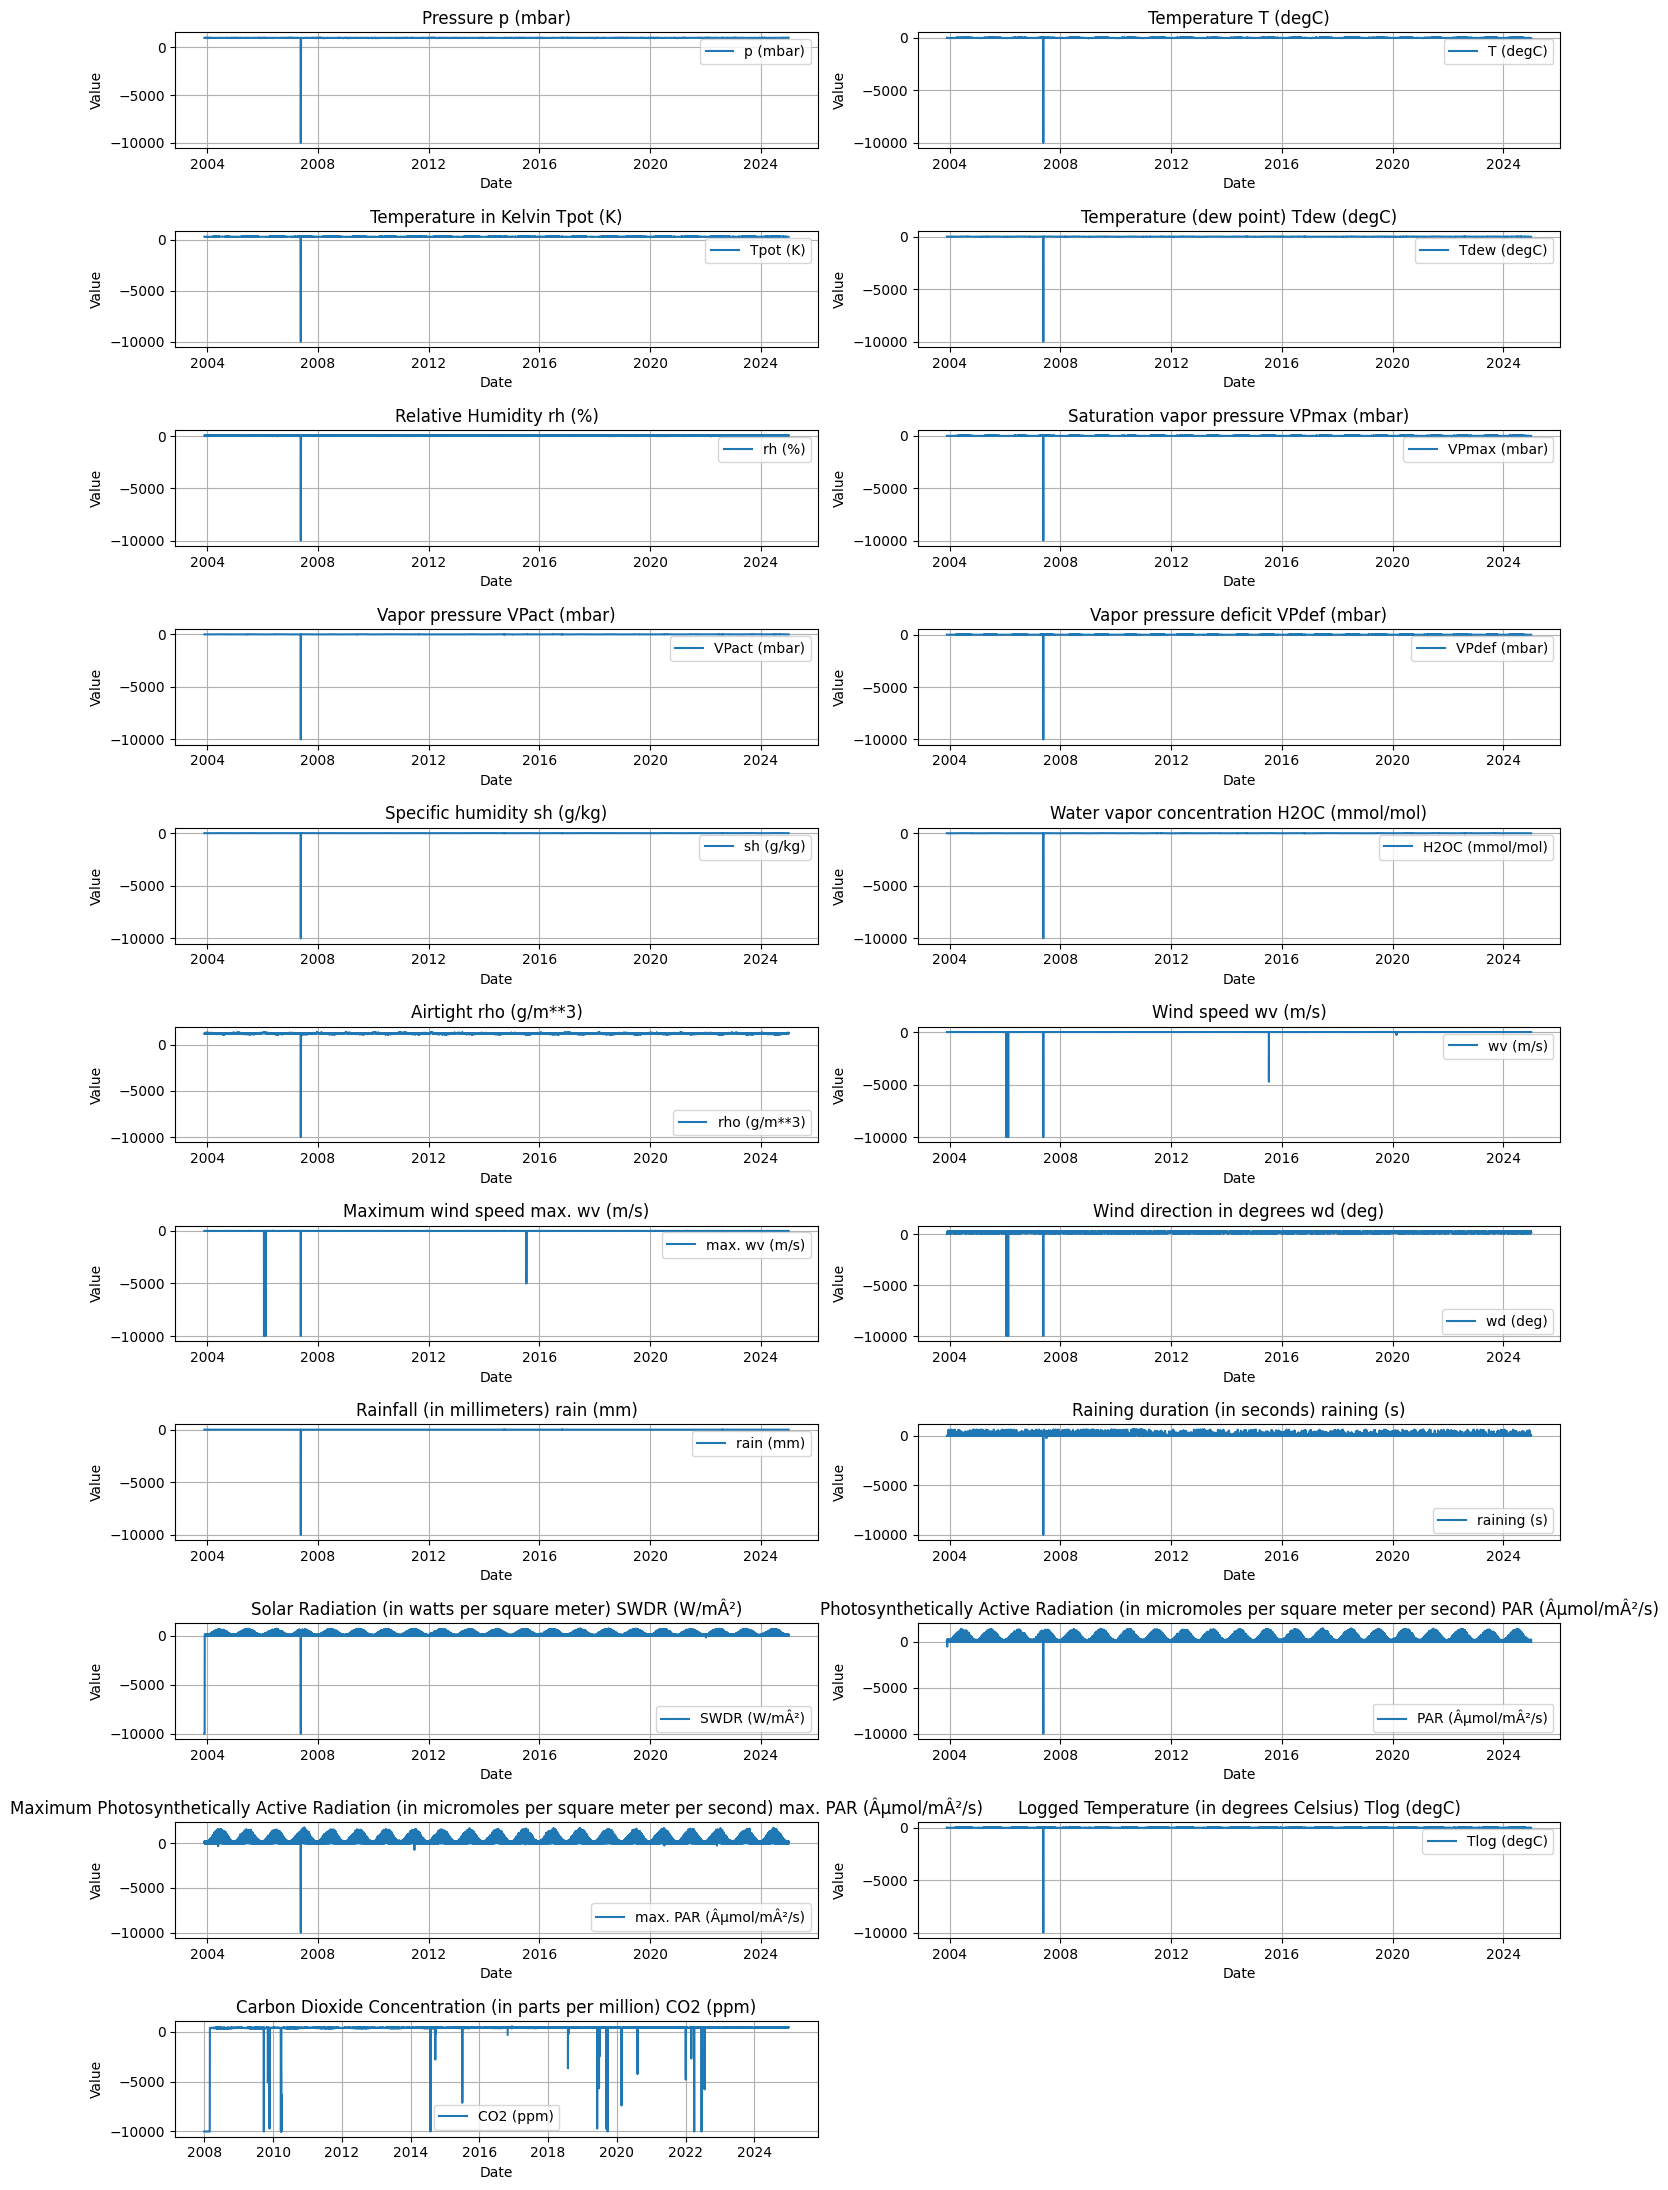

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

data = pd.read_csv("../processed/mpi_roof.csv", encoding='latin-1')
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
data = data.set_index("Date Time")

resample_data = data.resample('6h').mean()
initial_data = resample_data

plot(initial_data, titles)


### Check Initial Resampled Nan Values

In [11]:
print('Nan sum: ', initial_data.isna().sum())

Nan sum:  p (mbar)                    15
T (degC)                    15
Tpot (K)                    15
Tdew (degC)                 15
rh (%)                      15
VPmax (mbar)                15
VPact (mbar)                15
VPdef (mbar)                15
sh (g/kg)                   15
H2OC (mmol/mol)             15
rho (g/m**3)                15
wv (m/s)                    15
max. wv (m/s)               15
wd (deg)                    15
rain (mm)                   15
raining (s)                 15
SWDR (W/mÂ²)                15
PAR (Âµmol/mÂ²/s)           15
max. PAR (Âµmol/mÂ²/s)      15
Tlog (degC)                 15
CO2 (ppm)                 6009
dtype: int64


### Fill Nan Values

In [12]:
resample_row = resample_data.shape[0]

#Check for nan values in the resampled dataset
for i in resample_data.columns:
    resample_data[i] = resample_data[i].interpolate(method='linear', limit_direction='both')

print('Nan sum: ', resample_data.isna().sum())  



Nan sum:  p (mbar)                  0
T (degC)                  0
Tpot (K)                  0
Tdew (degC)               0
rh (%)                    0
VPmax (mbar)              0
VPact (mbar)              0
VPdef (mbar)              0
sh (g/kg)                 0
H2OC (mmol/mol)           0
rho (g/m**3)              0
wv (m/s)                  0
max. wv (m/s)             0
wd (deg)                  0
rain (mm)                 0
raining (s)               0
SWDR (W/mÂ²)              0
PAR (Âµmol/mÂ²/s)         0
max. PAR (Âµmol/mÂ²/s)    0
Tlog (degC)               0
CO2 (ppm)                 0
dtype: int64


### Transform Data and Modify the Sensor-Error Values

In [13]:
#Conver from C to K
resample_data['T (degC)'] = resample_data['T (degC)'] + 273.15
resample_data['Tdew (degC)'] = resample_data['Tdew (degC)'] + 273.15
resample_data['Tlog (degC)'] = resample_data['Tlog (degC)'] + 273.15

resample_data.rename(columns={'T (degC)': 'T (K)'}, inplace=True)
resample_data.rename(columns={'Tdew (degC)': 'Tdew (K)'}, inplace=True)
resample_data.rename(columns={'Tlog (degC)': 'Tlog (K)'}, inplace=True)

#Replace negative numbers
replace_data = resample_data
replace_data['T (K)'] = replace_data['T (K)'].apply(lambda x: np.nan if x < 243.15 else x)
replace_data['Tdew (K)'] = replace_data['Tdew (K)'].apply(lambda x: np.nan if x < 243.15 else x)
replace_data['Tpot (K)'] = replace_data['Tpot (K)'].apply(lambda x: np.nan if x < 243.15 else x)
replace_data['Tlog (K)'] = replace_data['Tlog (K)'].apply(lambda x: np.nan if x < 243.15 else x)

resample_data[['T (K)', 'Tdew (K)', 'Tpot (K)', 'Tlog (K)']] = replace_data[['T (K)', 'Tdew (K)', 'Tpot (K)', 'Tlog (K)']]
replace_data = replace_data.drop(columns=['T (K)', 'Tdew (K)', 'Tpot (K)', 'Tlog (K)'])

for i in replace_data.columns:
    resample_data[i] = replace_data[i].apply(lambda x: 0 if x < 0 else x)

#Check for nan values in the resampled dataset
for i in resample_data.columns:
    resample_data[i] = resample_data[i].interpolate(method='linear', limit_direction='both')



### Plot the Modified Data

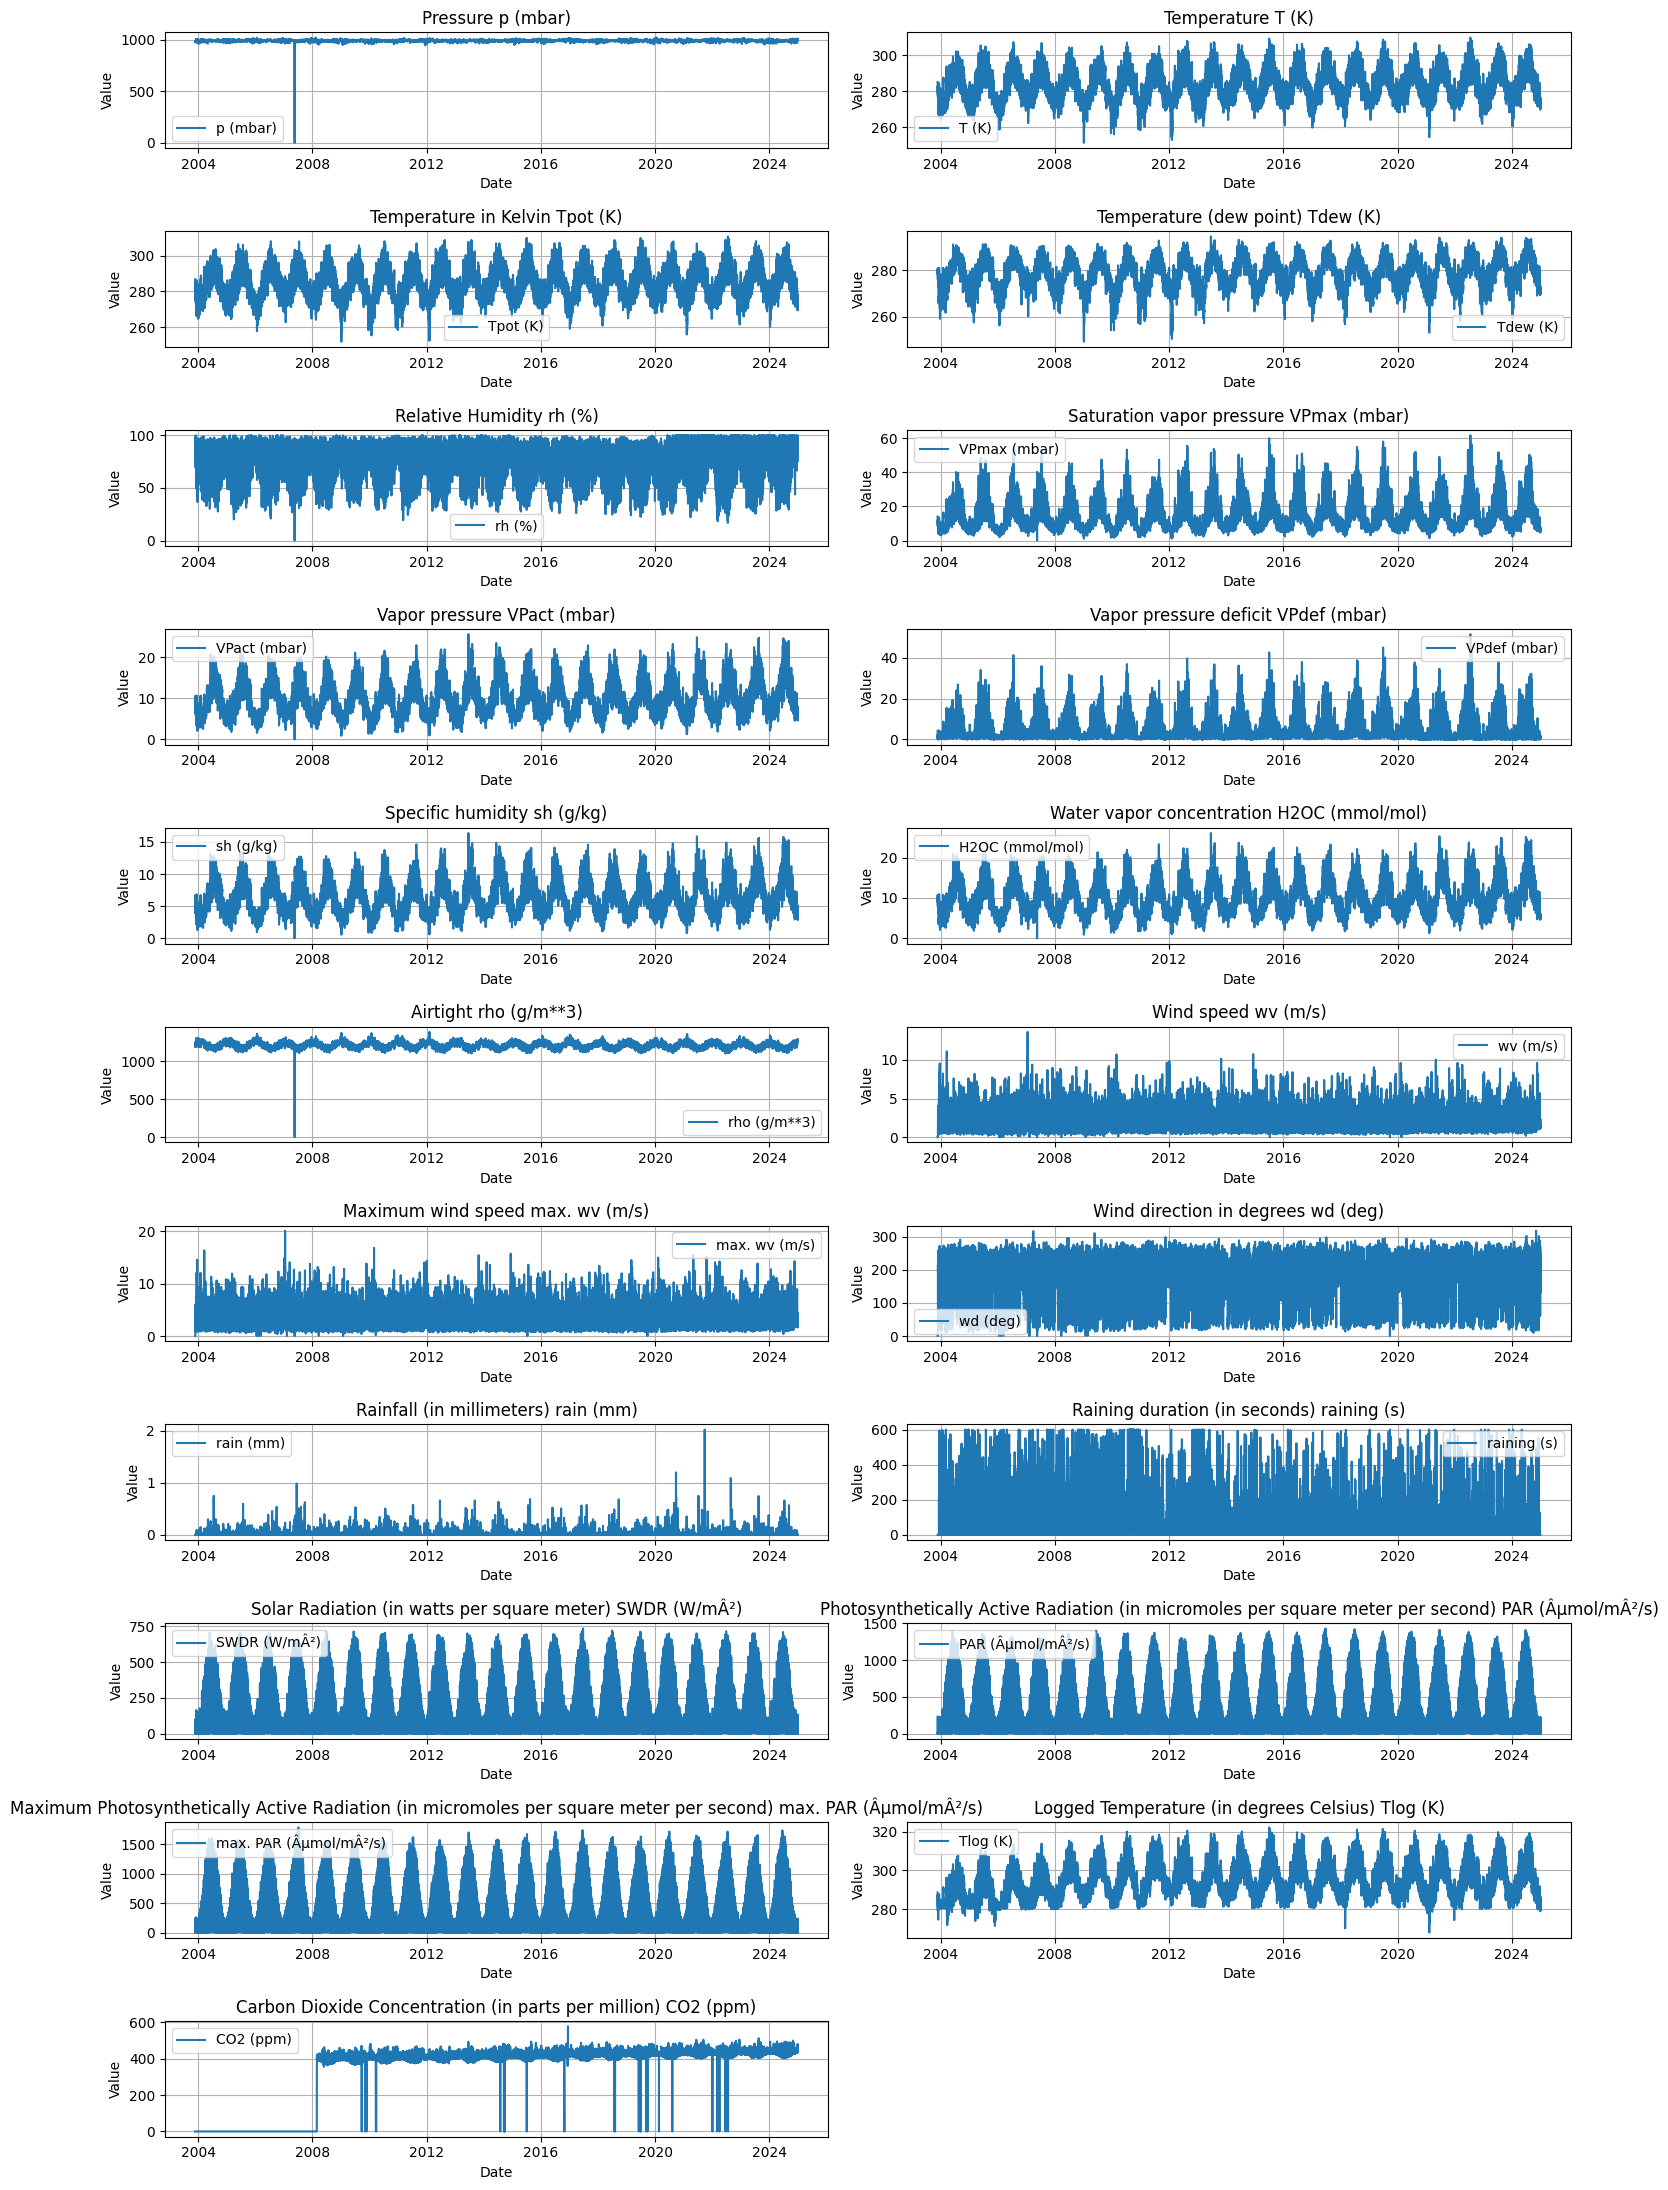

In [14]:
plot(resample_data, titles)

### Add Rain Rate, Is Rain and Rain Type Columns

In [15]:
resample_data['Rain_Rate (mm/h)'] = np.where((resample_data['raining (s)'] > 0), (resample_data['rain (mm)'] * 3600) / resample_data['raining (s)'], 0)
resample_data['Is_Rain'] = np.where(resample_data['Rain_Rate (mm/h)'] >= 0.5, 'Yes', 'No')

rain_condition = ['No_Rain', 'Weak_Rain', 'Moderate_Rain', 'Heavy_Rain', 'Very_Heavy_Rain', 'Shower', 'Cloudburst']
rain_rate = [resample_data['Rain_Rate (mm/h)'] < 0.5,
             (resample_data['Rain_Rate (mm/h)'] >= 0.5) & (resample_data['Rain_Rate (mm/h)'] < 2),
             (resample_data['Rain_Rate (mm/h)'] >= 2) & (resample_data['Rain_Rate (mm/h)'] < 6),
             (resample_data['Rain_Rate (mm/h)'] >= 6) & (resample_data['Rain_Rate (mm/h)'] < 10),
             (resample_data['Rain_Rate (mm/h)'] >= 10) & (resample_data['Rain_Rate (mm/h)'] < 18),
             (resample_data['Rain_Rate (mm/h)'] >= 18) & (resample_data['Rain_Rate (mm/h)'] < 30),
             resample_data['Rain_Rate (mm/h)'] >= 30]
resample_data['Rain_Type'] = np.select(rain_rate, rain_condition, default='Unknown')

### Preprocess Data

In [16]:
is_rain = resample_data.drop(columns=['Rain_Type'])
resample_data.head()
is_rain.to_csv("../processed/is_rain.csv")

#Preprocessing data
scaler = StandardScaler()
robust = RobustScaler()
encoder = OneHotEncoder(sparse_output=False)
regression_data = resample_data.drop(columns=['Is_Rain', 'Rain_Type'])
categorical_columns = resample_data.select_dtypes(include=['object']).columns.tolist()

one_hot_encoded = encoder.fit_transform(resample_data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=resample_data.index)

regression_data_scaler = scaler.fit_transform(regression_data)
regression_data_df = pd.DataFrame(regression_data_scaler, columns=regression_data.columns, index=regression_data.index)

preprocessed_data = pd.concat([regression_data_df, one_hot_df], axis=1)
preprocessed_data.head()
preprocessed_data = preprocessed_data.drop(columns=['Is_Rain_No', 'Is_Rain_Yes'])
# preprocessed_data = preprocessed_data.dropna()
preprocessed_data.to_csv("../processed/rain_type.csv")